# AEROSOL INDEX

In [2]:
%%capture
!pip install xarray==0.20.2  #latest package 2022.6.0 doesn't work
!pip install s3fs
!pip install netcdf4
!pip install h5netcdf

!pip install geopandas --quiet
!pip install shapely --quiet
!pip install contextily --quiet

In [3]:
import s3fs
import h5netcdf
import netCDF4
import xarray as xr

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import contextily as cx

### LOOP THROUGH FOLDERS AND EXTRACT DATA

In [60]:
one_to_nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
ten_to_32 = list(range(10, 32))
for i in ten_to_32:
    i = str(i)
ten_to_32_str = [str(i) for i in ten_to_32]
subfolder_list = one_to_nine + ten_to_32_str
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [82]:
#reduce down to only looking at half a month
limit = math.ceil(len(subfolder_list)/2)
subfolder_list = subfolder_list[0:limit]
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [83]:
indices = [5, 6, 7, 8]   #take only keys at these indices from each subfolder, where we know london coverage appears
keys = []
for i in subfolder_list:
    bucket = 'meeo-s5p'
    subfolder = 'OFFL/L2__AER_AI/2022/06/' + i + '/'   #loop through June's subfolders

    conn = boto3.client('s3')
    #some folders e.g. 10 don't exist, continue loop when error for these non existent folders
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
    except:
        continue
    
    temp_list = []
    for f in contents:
        temp_list.append(f['Key'])
    
    for index in range(len(temp_list)):
        if index in indices:
            keys.append(temp_list[index])
            
keys[0:4]

['OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T085512_20220601T103642_24005_02_020301_20220602T224512.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T103642_20220601T121812_24006_02_020301_20220603T002447.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T121812_20220601T135942_24007_02_020301_20220603T020518.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T135942_20220601T154112_24008_02_020301_20220603T034452.nc']

In [105]:
len(keys)

60

In [86]:
#find .nc file where filtering does not result in 0 longitude or latitudes (or co)

uk_keys = []
count = 0
uk_df = pd.DataFrame() 
for i in keys:
    #extract data from netcdf5 as xarray dataset
    fs = s3fs.S3FileSystem(anon=True)
    f = fs.open('s3://meeo-s5p/' + i)
    ds = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')

    #collapse 3 dimensions
    ds = ds.sel(time=ds.time[0])
    ds = ds.drop_dims('corner')
    #only high quality data
    #ds = ds.where(ds.qa_value > 0.5, drop = True)
    #target parameter
    #ds = ds[['aerosol_index_354_388', 'qa_value']]    #keep qa value too, can filter later if want
    ds = ds[['aerosol_index_340_380', 'qa_value']]
    #uk filter
    #ds = ds.where((ds.latitude > 50.10319) & (ds.latitude < 60.15456), drop = True)
    #ds = ds.where((ds.longitude > -7.64133) & (ds.longitude < 1.75159), drop = True)
    #london filter
    ds = ds.where((ds.latitude > 51.239405) & (ds.latitude < 51.737184), drop = True)
    ds = ds.where((ds.longitude > -0.625211) & (ds.longitude < 0.328289), drop = True)

    #drop nas along remaining dimensions - NO, for transparency of method, NAs will be dropped from dataframe than xarray
    #ds = ds.dropna('scanline', how='any')
    #ds = ds.dropna('ground_pixel', how='any')
    
    count += 1
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.drop(['scanline', 'ground_pixel'], axis = 1)
    df = df.dropna(how = 'any')
    
    if len(df) == 0:
        print(str(count) + '/' + str(len(keys)), '\t', '---> NONE FOUND')
        continue
    else:
        print(str(count) + '/' + str(len(keys)), '\t', '---> UK COVERAGE FOUND')
        #append to uk keys list
        uk_keys.append(i)
        #append to uk dataframe
        uk_df = uk_df.append(df)
        continue

1/60 	 ---> NONE FOUND
2/60 	 ---> UK COVERAGE FOUND
3/60 	 ---> UK COVERAGE FOUND
4/60 	 ---> NONE FOUND
5/60 	 ---> NONE FOUND
6/60 	 ---> NONE FOUND
7/60 	 ---> UK COVERAGE FOUND
8/60 	 ---> NONE FOUND
9/60 	 ---> NONE FOUND
10/60 	 ---> UK COVERAGE FOUND
11/60 	 ---> NONE FOUND
12/60 	 ---> NONE FOUND
13/60 	 ---> NONE FOUND
14/60 	 ---> UK COVERAGE FOUND
15/60 	 ---> UK COVERAGE FOUND
16/60 	 ---> NONE FOUND
17/60 	 ---> NONE FOUND
18/60 	 ---> NONE FOUND
19/60 	 ---> NONE FOUND
20/60 	 ---> NONE FOUND
21/60 	 ---> NONE FOUND
22/60 	 ---> UK COVERAGE FOUND
23/60 	 ---> UK COVERAGE FOUND
24/60 	 ---> NONE FOUND
25/60 	 ---> NONE FOUND
26/60 	 ---> UK COVERAGE FOUND
27/60 	 ---> UK COVERAGE FOUND
28/60 	 ---> NONE FOUND
29/60 	 ---> NONE FOUND
30/60 	 ---> UK COVERAGE FOUND
31/60 	 ---> NONE FOUND
32/60 	 ---> NONE FOUND
33/60 	 ---> UK COVERAGE FOUND
34/60 	 ---> NONE FOUND
35/60 	 ---> NONE FOUND
36/60 	 ---> NONE FOUND
37/60 	 ---> NONE FOUND
38/60 	 ---> UK COVERAGE FOUND
39/60 

In [ ]:
uk_df.head()

In [88]:
len(uk_df)

941

In [104]:
#persist dataframe to local csv file        
uk_df.to_csv('ai_sentinel_01-16june.csv', index = False)

### MANUAL EDA OF DATA FOR METRIC (e.g. setup filters needed)

In [4]:
fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
f = fs.open('s3://meeo-s5p/OFFL/L2__AER_AI/2022/01/01/S5P_OFFL_L2__AER_AI_20220101T105540_20220101T123710_21864_02_020301_20220103T004626.nc')

# open xarray dataset
ds2 = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')   #or netcdf4

In [5]:
ds5 = ds2.copy()

In [6]:
ds5

<xarray.Dataset>
Dimensions:                          (scanline: 4172, ground_pixel: 450, time: 1, corner: 4)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2022-01-01
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

- aerosol_index_354_388 =
- aerosol_index_340_380 = 

CHOOSE ?

In [7]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [8]:
#filtering to 1 time essentially drops time dimension
ds5 = ds5.sel(time=ds5.time[0])

In [9]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [10]:
#only need scanline and ground_pixel dimensions for lon lat and co (see brackets)
ds5 = ds5.drop_dims('corner')

In [11]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [12]:
ds5

<xarray.Dataset>
Dimensions:                          (scanline: 4172, ground_pixel: 450)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
    time                             datetime64[ns] 2022-01-01
    latitude                         (scanline, ground_pixel) float32 ...
    longitude                        (scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (scanline) datetime64[ns] 2022-01-01T11:...
    time_utc                         (scanline) object b'2022-01-01T11:17:14....
    qa_value                         (scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (scanline, ground_pixel) float32 ...

In [13]:
#Recommend to ignore data with qa_value < 0.5 --> from data variable descriptor
#ds5 = ds5.where(ds5.qa_value > 0.5, drop = True)

In [14]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [15]:
#filter by qa value then by co column so that dropping NAs (afterwards) only occurs for co column (retain as much as possible)
#ds5 = ds5['aerosol_index_354_388']
ds5 = ds5['aerosol_index_340_380']

In [16]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [17]:
#uk filter latitude, 500m is the lowest of the 50 layers
#ds5 = ds5.where((ds5.latitude > 50.10319) & (ds5.latitude < 60.15456), drop = True)
#ds5 = ds5.where((ds5.longitude > -7.64133) & (ds5.longitude < 1.75159), drop = True)

#london filter
ds5 = ds5.where((ds5.latitude > 51.239405) & (ds5.latitude < 51.737184), drop = True)
ds5 = ds5.where((ds5.longitude > -0.625211) & (ds5.longitude < 0.328289), drop = True)

In [18]:
print(ds5.latitude.size)
ds5.longitude.size

14196


14196

In [19]:
#BEST DROPPING NAS FROM DATAFRAME RATHER THAN XARRAY AS CLEARER WHATS BEING DONE

#drops NAs in this dimension
#will remove all NAs of co

#how ({"any", "all"}, default: "any") –
#any : if any NA values are present, drop that label
#all : if all values are NA, drop that label

#if any of longitude, latitude or co have null values, that data record becomes useless, so drop any

#ds5 = ds5.dropna('scanline', how='any')
#ds5 = ds5.dropna('ground_pixel', how='any')

In [20]:
ds5

<xarray.DataArray 'aerosol_index_340_380' (scanline: 169, ground_pixel: 84)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 3.541e+03 3.542e+03 ... 3.708e+03 3.709e+03
  * ground_pixel  (ground_pixel) float64 48.0 49.0 50.0 ... 129.0 130.0 131.0
    time          datetime64[ns] 2022-01-01
    latitude      (scanline, ground_pixel) float32 46.94 46.98 ... 57.01 57.03
    longitude     (scanline, ground_pixel) float32 -0.5968 -0.4941 ... 0.3075
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 380 and 340 nm
    long_name:               Aerosol index from 380 and 340 nm
    radiation_wavelength:    [340. 380.]
    ancillary_variables:     aerosol_index_340_380_precision

In [21]:
df = ds5.to_dataframe()

In [22]:
df.head()

time   latitude  longitude  aerosol_index_340_380
scanline ground_pixel                                                        
3541.0   48.0         2022-01-01  46.939495  -0.596809                    NaN
         49.0         2022-01-01  46.983170  -0.494110                    NaN
         50.0         2022-01-01  47.026123  -0.392609                    NaN
         51.0         2022-01-01  47.068375  -0.292274                    NaN
         52.0         2022-01-01  47.109943  -0.193075                    NaN

In [23]:
len(df)

14196

In [24]:
df = df.reset_index()

In [25]:
df.head()

,scanline,ground_pixel,time,latitude,longitude,aerosol_index_340_380
0,3541.0,48.0,2022-01-01,46.939495,-0.596809,NaN
1,3541.0,49.0,2022-01-01,46.983170,-0.494110,NaN
2,3541.0,50.0,2022-01-01,47.026123,-0.392609,NaN
3,3541.0,51.0,2022-01-01,47.068375,-0.292274,NaN
4,3541.0,52.0,2022-01-01,47.109943,-0.193075,NaN


In [26]:
df.columns

Index(['scanline', 'ground_pixel', 'time', 'latitude', 'longitude',
       'aerosol_index_340_380'],
      dtype='object')

In [27]:
df = df.drop(['scanline', 'ground_pixel'], axis = 1)
df.head()

,time,latitude,longitude,aerosol_index_340_380
0,2022-01-01,46.939495,-0.596809,NaN
1,2022-01-01,46.983170,-0.494110,NaN
2,2022-01-01,47.026123,-0.392609,NaN
3,2022-01-01,47.068375,-0.292274,NaN
4,2022-01-01,47.109943,-0.193075,NaN


In [28]:
#print('Number of NAs:', df['aerosol_index_354_388'].isnull().sum())
print('Number of NAs:', df['aerosol_index_340_380'].isnull().sum())

Number of NAs: 14096


In [29]:
df = df.dropna(how = 'any')

In [30]:
df.head()

,time,latitude,longitude,aerosol_index_340_380
5745,2022-01-01,51.245838,0.211708,0.830048
5746,2022-01-01,51.274513,0.290674,0.251221
5828,2022-01-01,51.263016,0.099561,0.450058
5829,2022-01-01,51.292065,0.179176,0.198863
5830,2022-01-01,51.320759,0.258201,0.214139


In [31]:
len(df)

100

In [32]:
df.duplicated().value_counts()

False    100
dtype: int64

### MAPPING LATITUDES AND LONGITUDES

In [33]:
#df = uk_df

In [34]:
lalo_data = df[['longitude', 'latitude']]
lalo_data.head()

,longitude,latitude
5745,0.211708,51.245838
5746,0.290674,51.274513
5828,0.099561,51.263016
5829,0.179176,51.292065
5830,0.258201,51.320759


In [35]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong

london_map['geometry'] = london_map['geometry'].to_crs(epsg=3857)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [36]:
def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=400, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('AI_sentinel_london_satellite.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

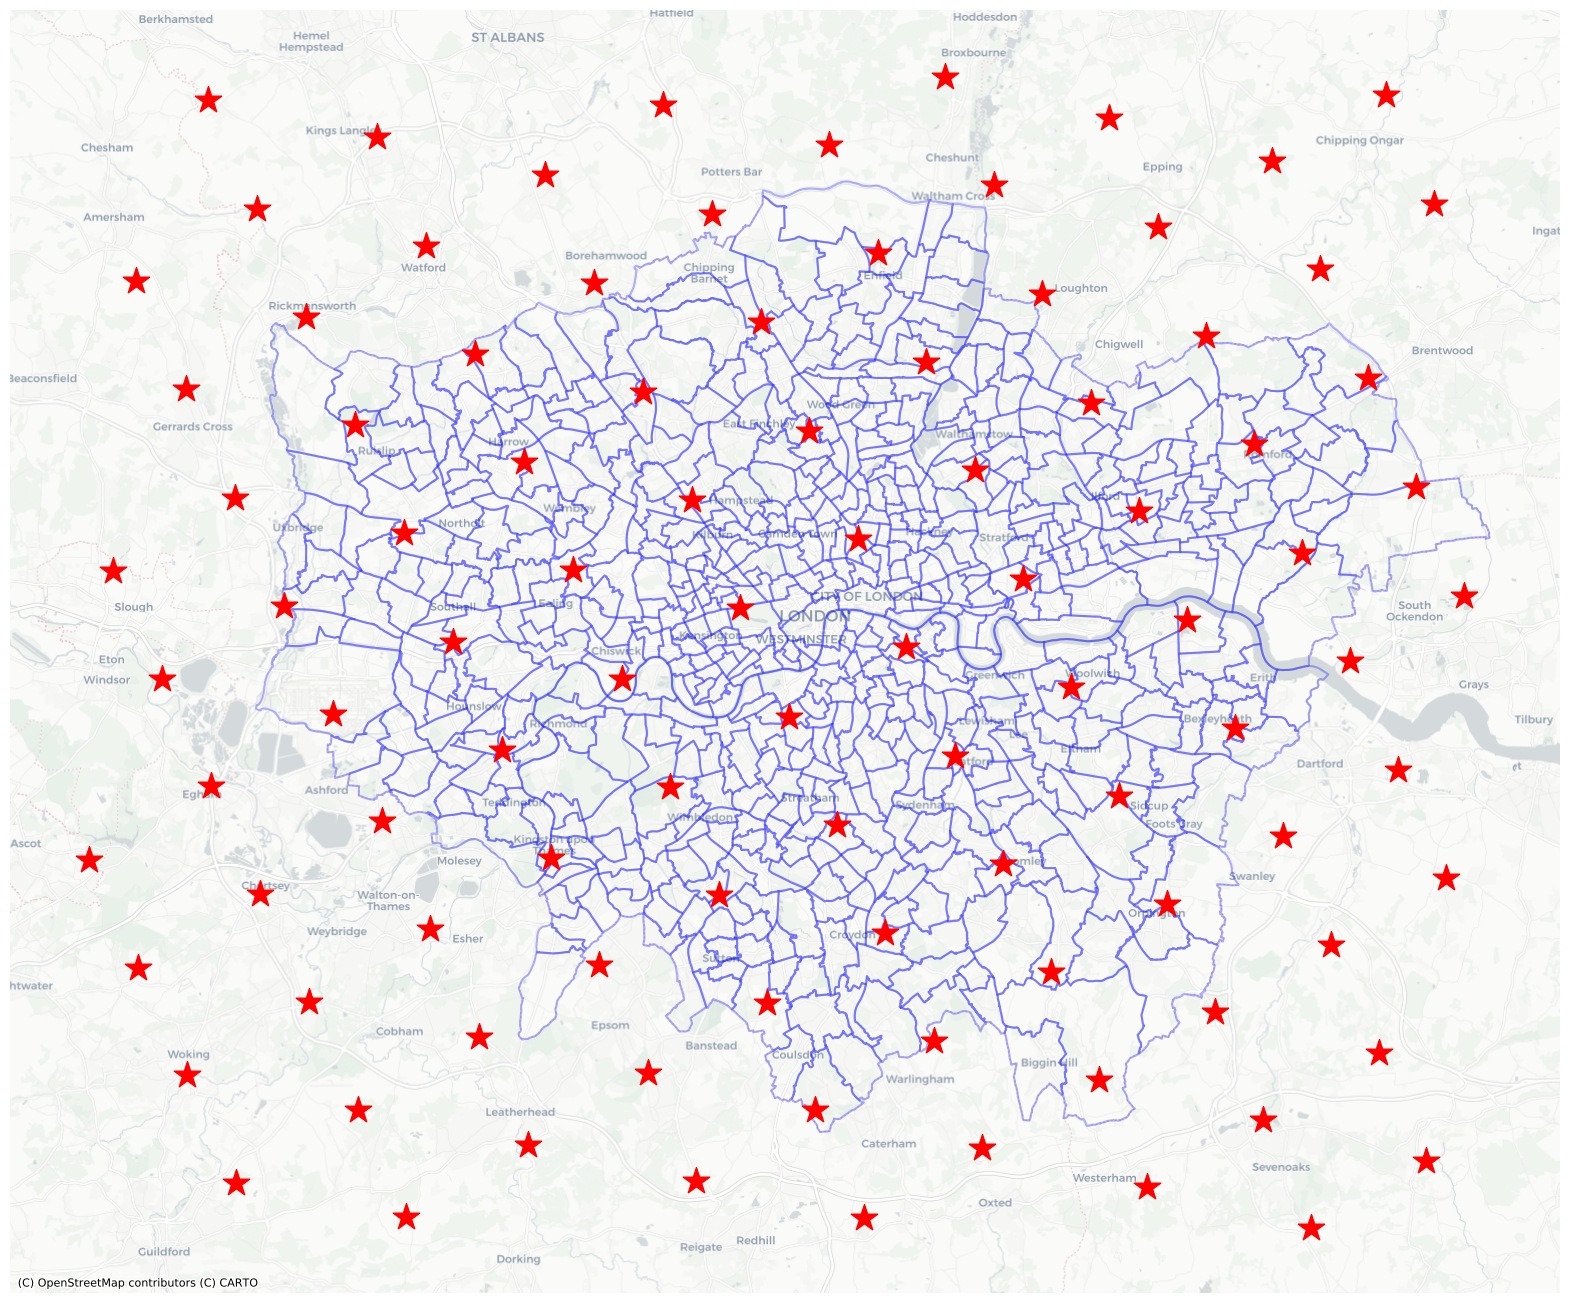

In [37]:
makeLayeredMap(london_map, gdf)